<a href="https://colab.research.google.com/github/kathy-f258/Data_Analyst_Portfolio/blob/main/Data_Analyst_Portfolio%20/%D0%94%D0%B8%D0%B7%D0%B0%D0%B9%D0%BD%20%D0%90%D0%92-%D1%82%D0%B5%D1%81%D1%82%D0%B0/AB_test_push_%D0%A4%D0%BE%D0%BB%D0%BE%D0%BC%D0%B5%D0%B5%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, pearsonr
from scipy.stats import mannwhitneyu

## 1. Импорт и анализ таблиц

#### Основная таблица с данными

- id_order — уникальный идентификатор покупки.
- id_client — уникальный идентификатор клиента.
- amt_payment — размер платежа.
- dtime_pay — дата и время оплаты.

In [ ]:

path = 'https://docs.google.com/spreadsheets/d/1msekgbBB3nxc3_1AQrQG3qEanS0fxZiB/export?format=xlsx&ouid=114206339311256990708&rtpof=true&sd=true'
df_data = pd.read_excel(path, sheet_name='Данные')

df_data.head()

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468


In [ ]:
# Проверка типов данных и кол-ва строк
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37989 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_order     37989 non-null  int64         
 1   id_client    37401 non-null  float64       
 2   amt_payment  35845 non-null  float64       
 3   dtime_pay    35560 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.2 MB


In [ ]:
# Проверка нуловых значений
df_data.isna().sum()

,0
id_order,0
id_client,588
amt_payment,2144
dtime_pay,2429


Мы видим,что в датафрейме много нуловых значений (по некоторым столбцам - более 5%).
- id_client - покупка без зарегистрированного клиента -> не заменям на 0, так как может быть воспринят как реальный ID
- amt_payment - платеж не поступил (ещё не оплатили или отмена) -> можем заменить на 0 и трактовать как "не оплачено"
- dtime_pay - дата отсутствует/платеж не совершен ->  логично оставить NaT, т.к. 0 или фиктивная дата исказят данные, оставим значения нулов для маркировки "оплачено/не оплачено"

In [ ]:
# Заменим нулы на 0 в amt_payment
df_data['amt_payment'] = df_data['amt_payment'].fillna(0)

In [ ]:
# Убираем строки без клиента
df_data = df_data.dropna(subset=['id_client'])

In [ ]:
df_data.isna().sum()

,0
id_order,0
id_client,0
amt_payment,0
dtime_pay,1841


#### Таблица с данными клиентов

- id_client — уникальный идентификатор клиента.
- dtime_ad — дата и время показа рекламного объявления (или баннером в приложении, или пуш-уведомлением, в зависимости от группы).
- nflag_test — группа эксперимента (0 — контроль, 1 — тест).
- id_trading_point — идентификатор торговой точки, к которой прикреплен данный пользователь.

In [ ]:
path = 'https://docs.google.com/spreadsheets/d/1msekgbBB3nxc3_1AQrQG3qEanS0fxZiB/export?format=xlsx&ouid=114206339311256990708&rtpof=true&sd=true'
df_clients = pd.read_excel(path, sheet_name='Clients')

df_clients.head()

,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


In [ ]:
# Проверка типов данных и кол-ва строк
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55605 entries, 0 to 55604
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_client         55605 non-null  int64         
 1   dtime_ad          55356 non-null  datetime64[ns]
 2   nflag_test        55605 non-null  int64         
 3   id_trading_point  55605 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.7 MB


In [ ]:
# Проверка нуловых значений
df_clients.isna().sum()

,0
id_client,0
dtime_ad,249
nflag_test,0
id_trading_point,0


In [ ]:
df_clients[df_clients['dtime_ad'].isna()]['nflag_test'].value_counts()

,count
nflag_test,
0,133
1,116


Мы видим нуловые записи в столбце dtime_ad, что может означать,что реклама не была показана пользователю, возможно, из-за технической ошибки  -> данные не несут смысловой нагрузки и лучше их исключить.

In [ ]:
# Убираем строки с нулами в dtime_ad
df_clients = df_clients.dropna(subset=['dtime_ad'])

#### Таблица с данными регионов

- id_trading_point — уникальный идентификатор торговой точки, к которой прикреплен данный пользователь.
- city — название города.

In [ ]:
path = 'https://docs.google.com/spreadsheets/d/1msekgbBB3nxc3_1AQrQG3qEanS0fxZiB/export?format=xlsx&ouid=114206339311256990708&rtpof=true&sd=true'
df_region = pd.read_excel(path, sheet_name='Region_dict')

df_region

,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир
...,...,...
61,3987,Москва
62,6543,Москва
63,8543,Москва
64,9121,Москва


#### Количество торговых точек в каждом городе

In [ ]:
df_trpoints = (df_region.groupby('city')['id_trading_point']
    .nunique()
    .reset_index()
    .rename(columns={'id_trading_point': 'cnt_points'})
    .sort_values('cnt_points', ascending=False))

df_trpoints

,city,cnt_points
7,Москва,11
15,Санкт-Петербург,11
4,Казань,6
10,Новосибирск,6
6,Красноярск,5
14,Самара,4
5,Краснодар,4
16,Саратов,2
18,Сочи,2
8,Мурманск,2


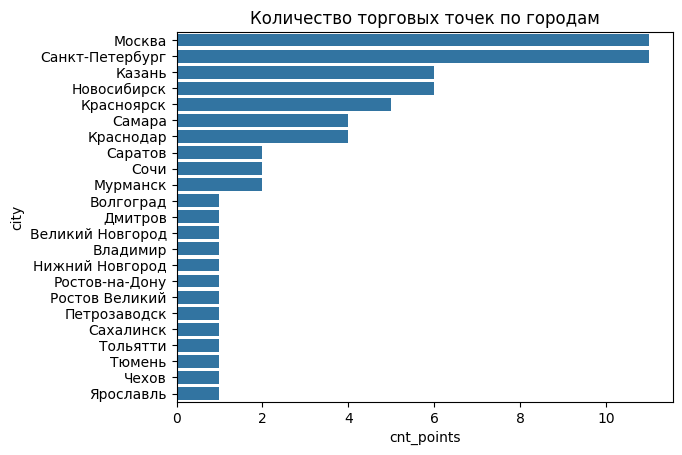

In [ ]:
# Визуализируем
sns.barplot(data=df_trpoints, x='cnt_points', y='city')
plt.title('Количество торговых точек по городам')
plt.show()

## 2. Объединение таблиц

In [ ]:
# Считаем суммарные платежи на каждого клиента

df_pay = (df_data.groupby('id_client')['amt_payment']
        .sum()
        .reset_index()
        .rename(columns={'amt_payment': 'total_payment'})
          )
df_pay.head(10)

,id_client,total_payment
0,178561.0,3052.0
1,178562.0,2439.0
2,178563.0,768.0
3,178564.0,0.0
4,178565.0,958.0
5,178566.0,5474.0
6,178567.0,2663.0
7,178568.0,13537.0
8,178569.0,2008.0
9,178570.0,6651.0


In [ ]:
# Объединяем сгруппированную таблицу с платежами с клиентской таблицей. Используем RIGHT JOIN, дл ятого, чтобы ни один клиент не был потерян.
df_clients_full = df_pay.merge(df_clients ,  on='id_client', how='right')
df_clients_full.head(10)

,id_client,total_payment,dtime_ad,nflag_test,id_trading_point
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212
1,226069.0,NaN,2022-07-11 16:28:38.511,1,54
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991
3,322530.0,NaN,2022-07-08 08:56:08.714,0,1015
4,254313.0,NaN,2022-06-19 22:18:01.770,1,453
5,195818.0,4021.0,2022-07-16 01:30:59.088,1,2652
6,267165.0,NaN,2022-06-25 09:54:06.470,0,866
7,246645.0,NaN,2022-07-03 22:13:08.299,0,1099
8,274394.0,NaN,2022-06-25 00:46:07.492,1,2652
9,200225.0,4372.0,2022-07-27 00:18:47.370,0,453


In [ ]:
# В объединенной таблице есть клиенты, которые не совершали покупок, заменим нулы на 0
df_clients_full['total_payment'] = df_clients_full['total_payment'].fillna(0)
df_clients_full.head(10)

,id_client,total_payment,dtime_ad,nflag_test,id_trading_point
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212
1,226069.0,0.0,2022-07-11 16:28:38.511,1,54
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991
3,322530.0,0.0,2022-07-08 08:56:08.714,0,1015
4,254313.0,0.0,2022-06-19 22:18:01.770,1,453
5,195818.0,4021.0,2022-07-16 01:30:59.088,1,2652
6,267165.0,0.0,2022-06-25 09:54:06.470,0,866
7,246645.0,0.0,2022-07-03 22:13:08.299,0,1099
8,274394.0,0.0,2022-06-25 00:46:07.492,1,2652
9,200225.0,4372.0,2022-07-27 00:18:47.370,0,453


In [ ]:
# С помощью словаря регионов подтягиваем к каждой торговой точке город, в котором она находится.
df_clients_full = df_clients_full.merge(df_region, on='id_trading_point', how='left')
df_clients_full.head(10)

,id_client,total_payment,dtime_ad,nflag_test,id_trading_point,city
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск
1,226069.0,0.0,2022-07-11 16:28:38.511,1,54,Мурманск
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991,Казань
3,322530.0,0.0,2022-07-08 08:56:08.714,0,1015,Краснодар
4,254313.0,0.0,2022-06-19 22:18:01.770,1,453,Санкт-Петербург
5,195818.0,4021.0,2022-07-16 01:30:59.088,1,2652,Москва
6,267165.0,0.0,2022-06-25 09:54:06.470,0,866,Новосибирск
7,246645.0,0.0,2022-07-03 22:13:08.299,0,1099,Краснодар
8,274394.0,0.0,2022-06-25 00:46:07.492,1,2652,Москва
9,200225.0,4372.0,2022-07-27 00:18:47.370,0,453,Санкт-Петербург


In [ ]:
# Создаем поле флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет (конверсия в покупку).
df_clients_full['flag_pay'] = np.where(df_clients_full['total_payment'] > 0, 1 ,0)
df_clients_full.head(10)

,id_client,total_payment,dtime_ad,nflag_test,id_trading_point,city,flag_pay
0,180844.0,5349.0,2022-06-08 18:38:41.414,0,212,Красноярск,1
1,226069.0,0.0,2022-07-11 16:28:38.511,1,54,Мурманск,0
2,183981.0,6322.0,2022-06-16 12:23:59.289,1,991,Казань,1
3,322530.0,0.0,2022-07-08 08:56:08.714,0,1015,Краснодар,0
4,254313.0,0.0,2022-06-19 22:18:01.770,1,453,Санкт-Петербург,0
5,195818.0,4021.0,2022-07-16 01:30:59.088,1,2652,Москва,1
6,267165.0,0.0,2022-06-25 09:54:06.470,0,866,Новосибирск,0
7,246645.0,0.0,2022-07-03 22:13:08.299,0,1099,Краснодар,0
8,274394.0,0.0,2022-06-25 00:46:07.492,1,2652,Москва,0
9,200225.0,4372.0,2022-07-27 00:18:47.370,0,453,Санкт-Петербург,1


## 3. Автоматизация статистических вычислений

#### Вычисление значения t-критерия (критерия Стьюдента)

Создадим функцию **test_calc**, которая будет вычислять значение **t-критерия** (критерия Стьюдента) и **p_value** для сравнения средних и с помощью функции print выводить сообщение о том, существует ли разница между средними (на основании p_value).

Аргуметы фукции:
- r1 - первая выборка
- r2 - вторая выборка
- alpha - уровень значимости, имеет значение по умолчанию 5%

In [ ]:
def test_calc (r1 , r2, alpha=0.05):
    t_stat, p_value = ttest_ind(r1, r2)

    print(f't‑критерий: {t_stat:.4e}')
    print(f'p‑value: {p_value:.4e}')
    print(f'Уровень значимости (alpha): {alpha}')

    if p_value <= alpha:
        print('Вывод: различия между средними статистически значимы (p_value <= alpha)')
        print('Нулевая гипотеза (о равенстве средних) отвергается')
    else:
        print('Вывод: различия между средними не являются статистически значимыми (p_value > alpha)')
        print('Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних')

    return t_stat, p_value


In [ ]:
# Делаем сегментацию
control_gr = df_clients_full[df_clients_full['nflag_test'] ==0]['total_payment']
test_gr = df_clients_full[df_clients_full['nflag_test'] ==1]['total_payment']

In [ ]:
# Проверим работу фукнции
test_calc (control_gr , test_gr, alpha=0.05)

t‑критерий: -6.5148e+00
p‑value: 7.3391e-11
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-6.514837079080246), np.float64(7.339058513839943e-11))

#### Вычисление значения U-критерия (критерия Манна Уитни)

Создадим функцию **mann_whitney_func**, которая будет рассчитывать значение **критерия Манна Уитни** и **p_value** для сравнения распределений и с помощью функции print выводить сообщение о том, существует ли разница между средними (на основании p_value).

Аргуметы фукции:
- r1 - первая выборка
- r2 - вторая выборка
- alpha - уровень значимости, имеет значение по умолчанию 5%

In [ ]:
def mann_whitney_func (r1 , r2, alpha=0.05):
    mw_stat, p_value = mannwhitneyu(r1, r2)

    print(f'U-критерий Манна–Уитни: {mw_stat:.4e}')
    print(f'p‑value: {p_value:.4e}')
    print(f'Уровень значимости (alpha): {alpha}')

    if p_value <= alpha:
        print('Вывод: различия между распределениями статистически значимы (p_value <= alpha)')
        print('Нулевая гипотеза (о равенстве средних) отвергается')
    else:
        print('Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)')
        print('Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений')

    return mw_stat, p_value

In [ ]:
# Проверим работу фукнции
mann_whitney_func (control_gr , test_gr, alpha=0.05)

U-критерий Манна–Уитни: 3.6985e+08
p‑value: 2.2545e-10
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(369851091.5), np.float64(2.254499814955653e-10))

## 4. Чистка неверно заполненных точек

Создадим пустой список. Запустим цикл по всем торговым точкам и добавим к этому списку все торговые точки, в которых в тестовой или в контрольной группе не было заплачено ни одного рубля ни одним клиентом.

In [ ]:
no_pay = []

for i  in df_clients_full['id_trading_point'].unique():
    point_data = df_clients_full[df_clients_full['id_trading_point'] == i]

    test_pay = point_data[point_data['nflag_test'] == 1]['total_payment'].sum()
    control_pay = point_data[point_data['nflag_test'] == 0]['total_payment'].sum()

    if test_pay==0 or control_pay==0:
        no_pay.append(i)

print('Торговые точки без оплат в одной из групп:', no_pay)



Торговые точки без оплат в одной из групп: [np.int64(1015), np.int64(866), np.int64(1099), np.int64(739), np.int64(46), np.int64(228), np.int64(26), np.int64(603), np.int64(810), np.int64(800), np.int64(7), np.int64(23), np.int64(4), np.int64(1), np.int64(13)]


Создадим еще один пустой список. Запустим цикл по всем торговым точкам и добавьте к этому списку все торговые точки, в которых пустует или контрольная, или тестовая группа.

In [ ]:
no_point = []

for i in df_clients_full['id_trading_point'].unique():
    point_mis = df_clients_full[df_clients_full['id_trading_point'] == i]

    test_mis = point_mis[point_mis['nflag_test'] == 1]['nflag_test'].count()
    control_mis = point_mis[point_mis['nflag_test'] == 0]['nflag_test'].count()

    if test_mis == 0 or control_mis == 0:
        no_point.append(i)

print('Торговые точки, в которых пустует или контрольная, или тестовая группа:', no_point)

Торговые точки, в которых пустует или контрольная, или тестовая группа: [np.int64(1015), np.int64(866), np.int64(1099), np.int64(739), np.int64(228), np.int64(603), np.int64(810), np.int64(800)]


## 5. Расчет общих результатов A/B-теста

Отбросим все торговые точкив которых пустуют интересующие нас значения.
Пояснение: если сумма платежей или количество наблюдений в одной из групп будет равно 0, то мы не сможем сравнить платежи в тестовой и контрольной группах, или такое сравнение будет неверным.

In [ ]:
# создаем общий список исключений
points_to_remove = set(no_pay + no_point)
points_to_remove

{np.int64(1),
 np.int64(4),
 np.int64(7),
 np.int64(13),
 np.int64(23),
 np.int64(26),
 np.int64(46),
 np.int64(228),
 np.int64(603),
 np.int64(739),
 np.int64(800),
 np.int64(810),
 np.int64(866),
 np.int64(1015),
 np.int64(1099)}

In [ ]:
# Фильтруем наш основной датасет
df_clients_full = df_clients_full[~df_clients_full['id_trading_point'].isin(points_to_remove)]

#### Оценка средних платежей

In [ ]:
control_gr = df_clients_full[df_clients_full['nflag_test'] ==0]['total_payment']
test_gr = df_clients_full[df_clients_full['nflag_test'] ==1]['total_payment']

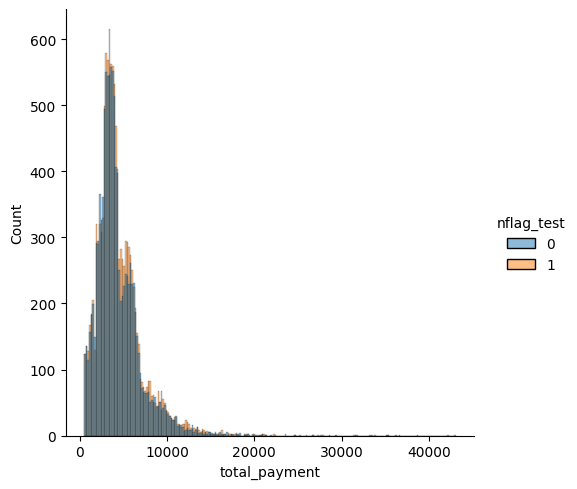

In [ ]:
# Строим гистограмму платежей
sns.displot(df_clients_full[df_clients_full['total_payment'] > 0], x = 'total_payment', hue = 'nflag_test')
plt.show()

In [ ]:
# Сравним средние платежи в контрольной и тестовой группах
df_gr = df_clients_full.groupby(['nflag_test']).agg({'total_payment':'mean'}).reset_index()
df_gr

,nflag_test,total_payment
0,0,2189.188432
1,1,2455.584585


In [ ]:
# Сравниваем средние платежи по всем торговым точкам - ранее делали сегментацию по котрольной и тестовой группе.
# Проведем t-тест:

test_calc (control_gr , test_gr, alpha=0.05)

t‑критерий: -9.5733e+00
p‑value: 1.0858e-21
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-9.573285274103036), np.float64(1.0857547123769503e-21))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_gr , test_gr, alpha=0.05)

U-критерий Манна–Уитни: 2.4317e+08
p‑value: 7.8294e-25
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(243171512.5), np.float64(7.829376257720135e-25))

***Выводы:***
- Полученные результаты двух тестов означают, что средние платежи между тестовой и контрольной группами статистически различаются — эксперимент оказал реальное влияние на поведение клиентов
- t‑тест (параметрический) и U‑тест (непараметрический) дают одинаковый вывод. Это повышает уверенность в результате, даже если предположения t‑теста (нормальность, равенство дисперсий) нарушены.
- Средний платеж по всем торговым точкам увеличился.

#### Оценка конверсий в платеж

In [ ]:
# Сравним средние платежи в контрольной и тестовой группах
df_gr_conv = df_clients_full.groupby(['nflag_test']).agg({'flag_pay':'sum'}).reset_index()
df_gr_conv

,nflag_test,flag_pay
0,0,11431
1,1,12207


In [ ]:
# Сделаем сегментацию по конверсии
control_gr_conv = df_clients_full[df_clients_full['nflag_test'] ==0]['flag_pay']
test_gr_conv = df_clients_full[df_clients_full['nflag_test'] ==1]['flag_pay']

In [ ]:
# Проведем t-тест:
test_calc (control_gr_conv , test_gr_conv, alpha=0.05)

t‑критерий: -9.4060e+00
p‑value: 5.3849e-21
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-9.406024876422881), np.float64(5.384854454774238e-21))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_gr_conv , test_gr_conv, alpha=0.05)

U-критерий Манна–Уитни: 2.4537e+08
p‑value: 5.6162e-21
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(245371284.5), np.float64(5.6162497735928165e-21))

***Выводы:***
- Полученные результаты двух тестов означают, что конверсии между тестовой и контрольной группами статистически различаются — эксперимент оказал реальное влияние на поведение клиентов.
- t‑тест (параметрический) и U‑тест (непараметрический) дают одинаковый вывод. Это повышает уверенность в результате, даже если предположения t‑теста (нормальность, равенство дисперсий) нарушены.
- Конверсия в платеж по всем торговым точкам увеличилась.

In [ ]:
# Сравним средние платежи  и конверсии в контрольной и тестовой группах  с группировкой по городам
df_gr_city = df_clients_full.groupby(['nflag_test','city']).agg({'total_payment':'mean','flag_pay':'sum'}).sort_values(by = 'city').reset_index()\
.rename(columns={'id_client': 'client_count', 'flag_pay':'conversion'})
df_gr_city

,nflag_test,city,total_payment,conversion
0,0,Владимир,2108.610197,303
1,1,Владимир,2547.220039,280
2,0,Волгоград,2601.761024,419
3,1,Волгоград,2288.870624,363
4,0,Дмитров,483.450704,7
5,1,Дмитров,579.333333,9
6,0,Казань,2610.688397,1224
7,1,Казань,2733.942000,1197
8,0,Краснодар,2912.431080,744
9,1,Краснодар,2696.804688,629


**(!) Как мы видим - результаты неоднозначны, не во всех городах введение нового способа уведомлений привело к росту конверсии и среднего платежа. Проведем сегментацию результатов.**

## 6. Сегментация результатов A/B-теста

#### Москва

In [ ]:
# Посмотрим на данные конверсий и средние платежи

df_gr_city_m = df_gr_city[df_gr_city['city']=='Москва']
df_gr_city_m

,nflag_test,city,total_payment,conversion
12,0,Москва,1986.180591,3037
13,1,Москва,2379.233779,3347


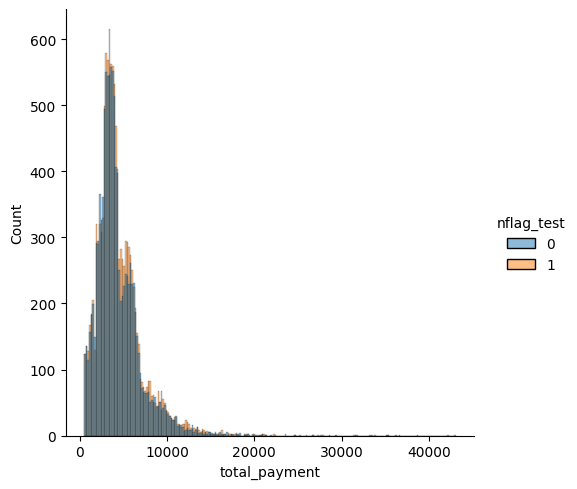

In [ ]:
sns.displot(df_clients_full[df_clients_full['total_payment'] > 0], x = 'total_payment', hue = 'nflag_test')
plt.show()

In [ ]:
# Сегментация для тестовой и контрольной групп  - средние платежи в Москве

control_gr_m = df_clients_full[(df_clients_full['nflag_test'] == 0) & (df_clients_full['city'] == 'Москва')]['total_payment']
test_gr_m = df_clients_full[(df_clients_full['nflag_test'] == 1) & (df_clients_full['city'] == 'Москва')]['total_payment']


In [ ]:
# Проведем t-тест :
test_calc (control_gr_m , test_gr_m, alpha=0.05)

t‑критерий: -7.8962e+00
p‑value: 3.1166e-15
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-7.896238614943354), np.float64(3.116649629630609e-15))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_gr_m , test_gr_m, alpha=0.05)

U-критерий Манна–Уитни: 1.7535e+07
p‑value: 8.6513e-17
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(17534818.5), np.float64(8.651256576787724e-17))

In [ ]:
# Сегментация для тестовой и контрольной групп - конверсии в Москве

control_conv_m = df_clients_full[(df_clients_full['nflag_test'] ==0) & (df_clients_full['city'] == 'Москва')]['flag_pay']
test_conv_m = df_clients_full[(df_clients_full['nflag_test'] ==1) & (df_clients_full['city'] == 'Москва')]['flag_pay']

In [ ]:
# Проведем t-тест:
test_calc (control_conv_m , test_conv_m, alpha=0.05)

t‑критерий: -6.4276e+00
p‑value: 1.3442e-10
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-6.427576036124008), np.float64(1.3442208722377196e-10))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_conv_m , test_conv_m, alpha=0.05)

U-критерий Манна–Уитни: 1.7988e+07
p‑value: 1.3888e-10
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(17987623.0), np.float64(1.3888194541373183e-10))

##### ***Вывод:***
##### Конверсия в покупку и средний платеж в тестовой группе в Москве увеличились, полученные результаты являются статистически значимыми.

#### Санкт-Петербург

In [ ]:
# Посмотрим на данные конверсий и средние платежи
df_gr_city_spb = df_gr_city[df_gr_city['city']=='Санкт-Петербург']
df_gr_city_spb

,nflag_test,city,total_payment,conversion
18,0,Санкт-Петербург,1913.558638,1988
19,1,Санкт-Петербург,2427.462542,2432


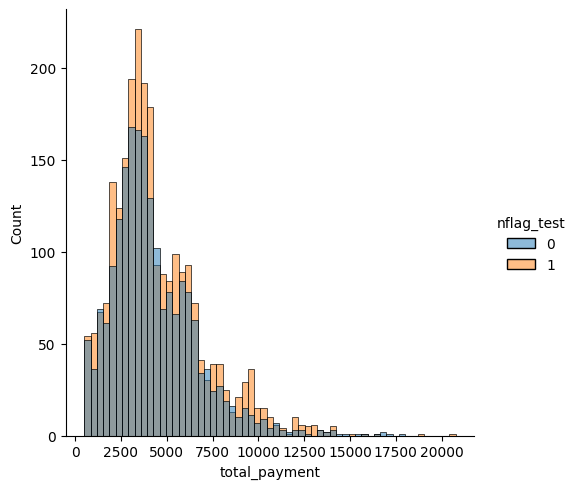

In [ ]:
sns.displot(df_clients_full[(df_clients_full['total_payment'] > 0) & (df_clients_full['city'] == 'Санкт-Петербург')], x = 'total_payment', hue = 'nflag_test')
plt.show()

In [ ]:
# Сегментация для тестовой и контрольной групп  - средние платежи в Санкт-Петербурге
control_gr_spb = df_clients_full[(df_clients_full['nflag_test'] == 0) & (df_clients_full['city'] == 'Санкт-Петербург')]['total_payment']
test_gr_spb = df_clients_full[(df_clients_full['nflag_test'] == 1) & (df_clients_full['city'] == 'Санкт-Петербург')]['total_payment']

In [ ]:
# Проведем t-тест:
test_calc (control_gr_spb , test_gr_spb, alpha=0.05)

t‑критерий: -8.7596e+00
p‑value: 2.3198e-18
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-8.759635784179547), np.float64(2.3198088937974163e-18))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_gr_spb , test_gr_spb, alpha=0.05)

U-критерий Манна–Уитни: 8.8094e+06
p‑value: 2.0392e-20
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(8809444.5), np.float64(2.0392184217953754e-20))

In [ ]:
# Сегментация для тестовой и контрольной групп - конверсии в Санкт-Петербурге

control_conv_spb = df_clients_full[(df_clients_full['nflag_test'] == 0) & (df_clients_full['city'] == 'Санкт-Петербург')]['flag_pay']
test_conv_spb = df_clients_full[(df_clients_full['nflag_test'] == 1) & (df_clients_full['city'] == 'Санкт-Петербург')]['flag_pay']

In [ ]:
# Проведем t-тест:
test_calc (control_gr_spb, test_gr_spb, alpha=0.05)

t‑критерий: -8.7596e+00
p‑value: 2.3198e-18
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(-8.759635784179547), np.float64(2.3198088937974163e-18))

In [ ]:
# Проведем U-тест:
mann_whitney_func (control_conv_spb , test_gr_spb, alpha=0.05)

U-критерий Манна–Уитни: 6.4637e+06
p‑value: 7.2225e-201
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


(np.float64(6463743.0), np.float64(7.222545745995519e-201))

##### ***Вывод:***
##### Конверсия в покупку и средний платеж в тестовой группе в Санкт-Петербурге увеличились, полученные результаты являются статистически значимыми.

#### Другие города

In [ ]:
# Посмотрим на данные конверсий и средние платежи во всех остальных городах
df_gr_city_oth = df_gr_city[(df_gr_city['city']!='Санкт-Петербург') & (df_gr_city['city']!='Москва')]
df_gr_city_oth

,nflag_test,city,total_payment,conversion
0,0,Владимир,2108.610197,303
1,1,Владимир,2547.220039,280
2,0,Волгоград,2601.761024,419
3,1,Волгоград,2288.870624,363
4,0,Дмитров,483.450704,7
5,1,Дмитров,579.333333,9
6,0,Казань,2610.688397,1224
7,1,Казань,2733.942000,1197
8,0,Краснодар,2912.431080,744
9,1,Краснодар,2696.804688,629


In [ ]:
# Выделим остальные города отдельным списком

cities_big = ['Москва', 'Санкт-Петербург']
other_cities = [city for city in df_clients_full['city'].unique() if city not in cities_big]


Красноярск


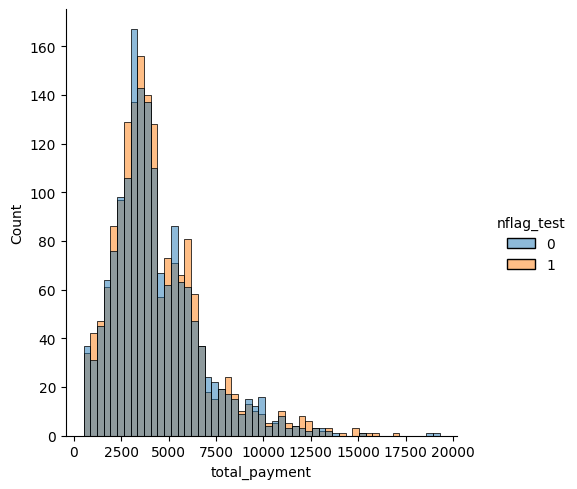

t‑критерий: -1.2001e-01
p‑value: 9.0448e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 4.4134e+06
p‑value: 8.7705e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: 2.7864e-01
p‑value: 7.8053e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Мурманск


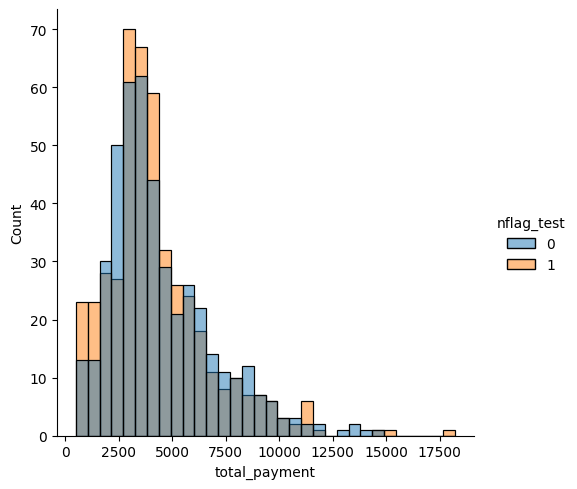

t‑критерий: -6.9025e-02
p‑value: 9.4498e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 5.5407e+05
p‑value: 5.4343e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -8.4601e-01
p‑value: 3.9764e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Казань


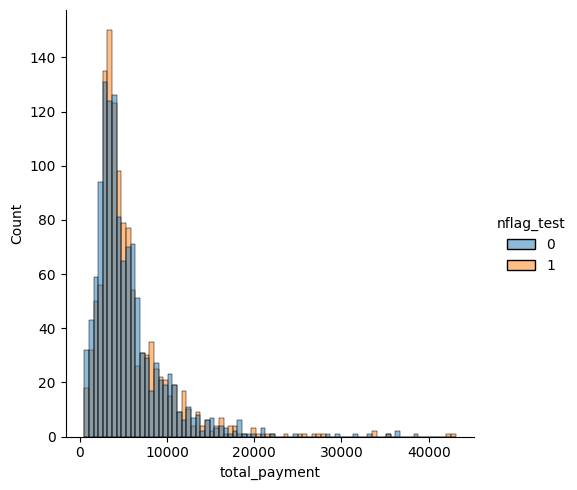

t‑критерий: -1.0831e+00
p‑value: 2.7882e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 3.1781e+06
p‑value: 3.7200e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -2.7304e-01
p‑value: 7.8483e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Саратов


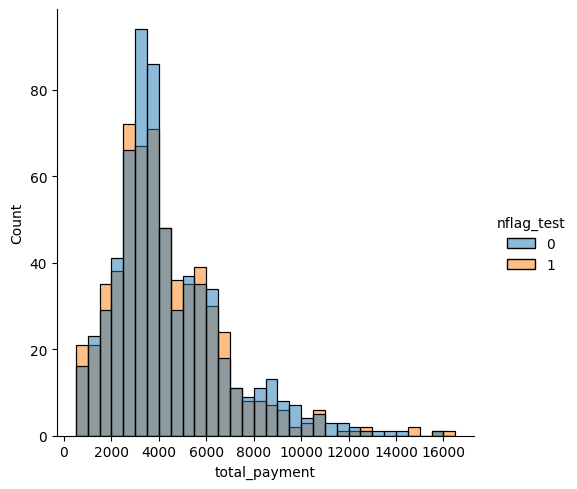

t‑критерий: 1.0517e-01
p‑value: 9.1625e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 5.5798e+05
p‑value: 7.8333e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -6.5079e-01
p‑value: 5.1526e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Тольятти


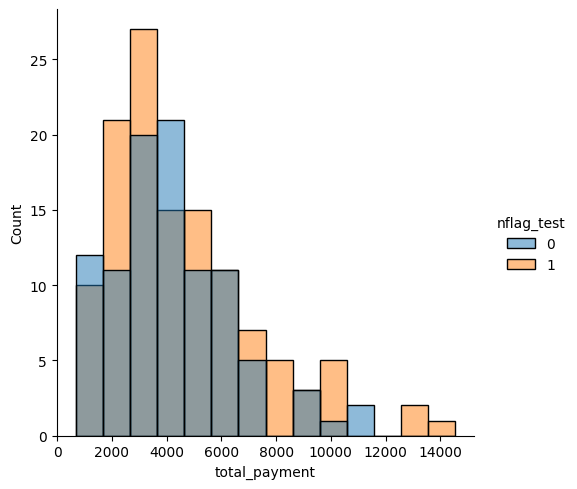

t‑критерий: -1.5046e+00
p‑value: 1.3333e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 1.4710e+04
p‑value: 2.2134e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -1.1851e+00
p‑value: 2.3675e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Тюмень


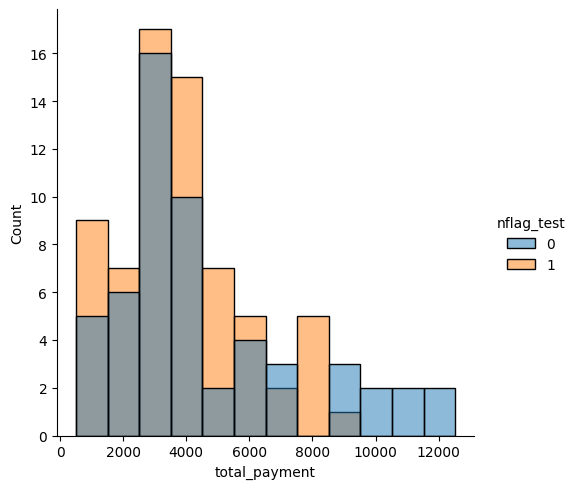

t‑критерий: -9.2646e-01
p‑value: 3.5502e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 8.2390e+03
p‑value: 3.8066e-02
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

t‑критерий: -2.4598e+00
p‑value: 1.4518e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


Волгоград


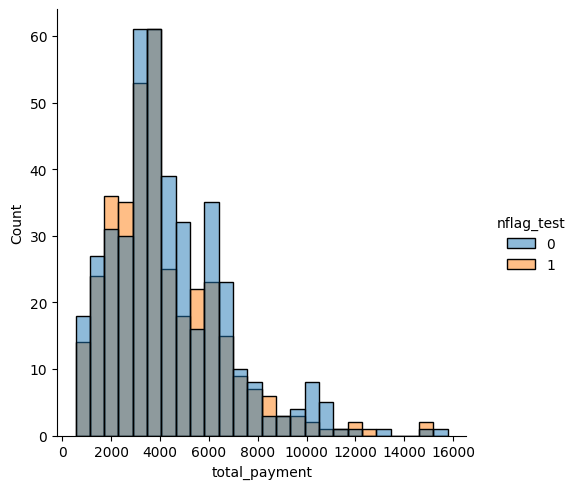

t‑критерий: 2.0893e+00
p‑value: 3.6869e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

U-критерий Манна–Уитни: 2.4574e+05
p‑value: 3.3239e-02
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

t‑критерий: 1.6222e+00
p‑value: 1.0499e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Сочи


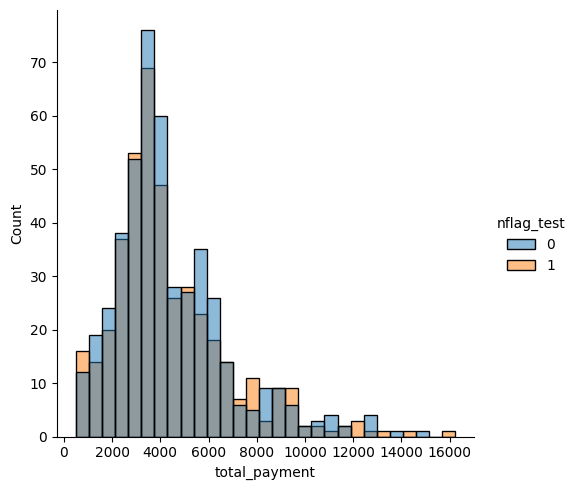

t‑критерий: 1.5432e+00
p‑value: 1.2298e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 3.3759e+05
p‑value: 5.6983e-02
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: 1.9850e+00
p‑value: 4.7320e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


Владимир


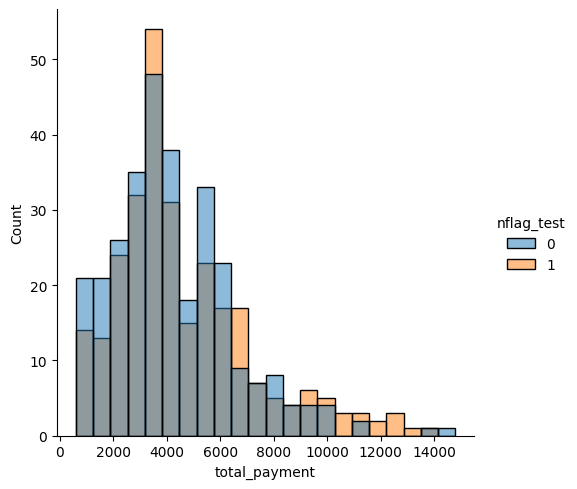

t‑критерий: -2.5770e+00
p‑value: 1.0095e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

U-критерий Манна–Уитни: 1.4385e+05
p‑value: 3.1668e-02
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

t‑критерий: -1.7249e+00
p‑value: 8.4816e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Самара


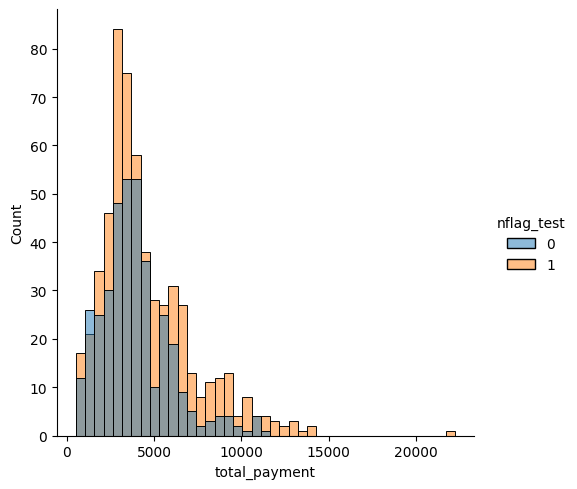

t‑критерий: -1.1541e+01
p‑value: 1.1014e-29
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

U-критерий Манна–Уитни: 2.3352e+05
p‑value: 4.3252e-30
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается

t‑критерий: -1.1846e+01
p‑value: 3.9814e-31
Уровень значимости (alpha): 0.05
Вывод: различия между средними статистически значимы (p_value <= alpha)
Нулевая гипотеза (о равенстве средних) отвергается


Краснодар


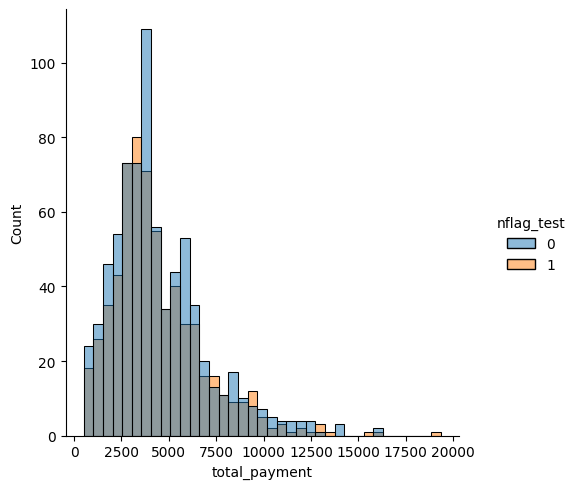

t‑критерий: 1.7188e+00
p‑value: 8.5800e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 6.0984e+05
p‑value: 5.9381e-02
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: 1.8790e+00
p‑value: 6.0385e-02
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Сахалинск


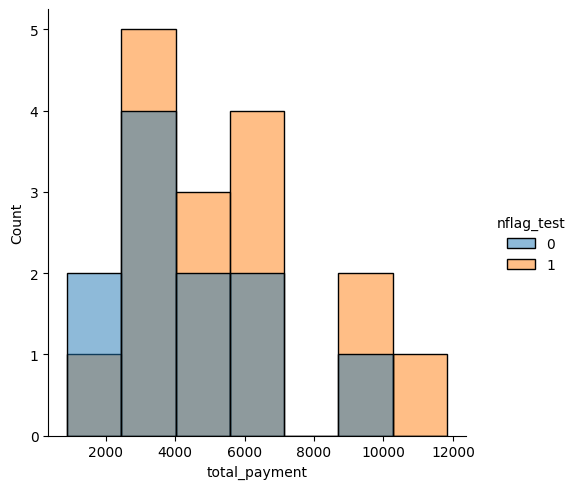

t‑критерий: -1.6271e+00
p‑value: 1.0581e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 2.6905e+03
p‑value: 1.9869e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -1.1704e+00
p‑value: 2.4367e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних


Дмитров


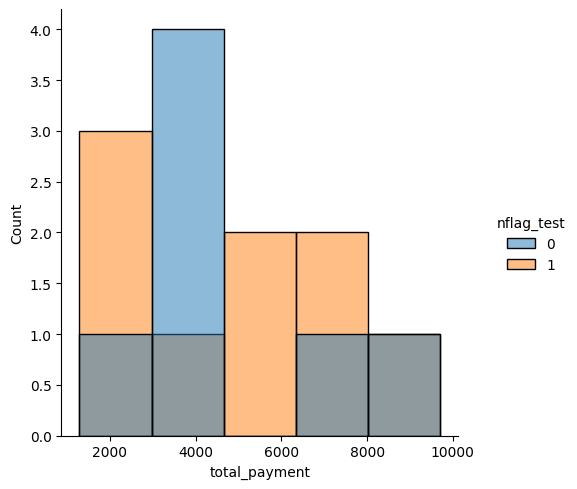

t‑критерий: -3.3105e-01
p‑value: 7.4108e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних

U-критерий Манна–Уитни: 2.7220e+03
p‑value: 7.4226e-01
Уровень значимости (alpha): 0.05
Вывод: различия между распределениями не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве распределений

t‑критерий: -3.2858e-01
p‑value: 7.4294e-01
Уровень значимости (alpha): 0.05
Вывод: различия между средними не являются статистически значимыми (p_value > alpha)
Нет достаточных оснований отвергнуть нулевую гипотезу о равенстве средних




In [ ]:
for i in other_cities:
    df_city = df_clients_full[df_clients_full['city']==i]
    print(i)
    control_gr = df_city[df_city['nflag_test'] ==0]['total_payment']
    test_gr = df_city[df_city['nflag_test'] ==1]['total_payment']

    control_gr_conv = df_city[df_city['nflag_test'] ==0]['flag_pay']
    test_gr_conv = df_city[df_city['nflag_test'] ==1]['flag_pay']

    sns.displot(df_city[df_city['total_payment'] > 0], x = 'total_payment', hue = 'nflag_test')
    plt.show()

    test_calc (control_gr , test_gr, alpha=0.05)
    print()
    mann_whitney_func (control_gr , test_gr, alpha=0.05)
    print()
    test_calc (control_gr_conv , test_gr_conv, alpha=0.05)
    print()
    print()

## 7. Отчет по A/B-тесту

Создадим итоговый общий датафрейм.
Описание полей:
- city - город.
- id_trading_point - уникальный идентификатор торговой точки, к которой прикреплен данный пользователь.
- count_test - кол-во наблюдений в тестовой группе.
- count_control - кол-во наблюдений в контрольной группе.
- count_all - суммарное кол-во наблюдений.
- percent_count - процент кол-ва наблюдений данной ТТ от всех наблюдений.
- avg_payment_test - средний платеж в тестовой группе.
- avg_payment_control - средний платеж в контрольной группе.
- diff - разница между средними платежами.
- sigma_test - стандартное отклонение платежей в тестовой группе.
- sigma_control - стандартное отклонение платежей в контрольной группе.
- ttest - значение статистического критерия (критерий Стьюдента для сравнения средних платежей).
- pvalue_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей).
- label_result - флаг результата( positive — тест дал положительный эффект, negative — тест ухудшил результат, neutral — разницы нет (p-value большое).

In [ ]:
# Создаем таблицу
df_final = pd.DataFrame(columns=['city', 'id_trading_point','count_test', 'count_control', 'count_all', 'percent_count'\
                                         ,'avg_payment_test', 'avg_payment_control', 'diff','sigma_test', 'sigma_control','ttest'\
                                         ,'pvalue_ttest', 'label_result'])
df_final

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,label_result


In [ ]:
# Считаем общее количество строк (для дальнейшего расчета доли ТТ от общего числа клиентов)
total_obs = len(df_clients_full)
total_obs

45318

In [ ]:
# Запускаем цикл по городам
for city in df_clients_full['city'].unique():
    df_city = df_clients_full[df_clients_full['city'] == city]
    for point in df_city['id_trading_point'].unique():  # Цикл по торговым точкам
        df_point = df_city[df_city['id_trading_point'] == point]

        # Тестовая и контрольная группа — только с оплатой
        test = df_point[(df_point['nflag_test'] == 1)]['total_payment']
        control = df_point[(df_point['nflag_test'] == 0)]['total_payment']
        # Подсчёт метрик
        count_test = len(test)
        count_control = len(control)
        count_all = count_test + count_control
        percent_count = (count_all / total_obs) * 100

        avg_test = test.mean()
        avg_control = control.mean()
        diff = avg_test - avg_control

        sigma_test = test.std()
        sigma_control = control.std()

        # t-тест
        t_stat, p_value = ttest_ind(test, control)

        # Лейбл результата
        alpha = 0.05
        if p_value < alpha:
            if diff > 0:
                label = 'positive'
            elif diff < 0:
                label = 'negative'
            else:
                label = 'neutral'
        else:
            label = 'neutral'

        # Создаём промежуточный DataFrame
        temp_df = pd.DataFrame({
            'city': [city],
            'id_trading_point': [point],
            'count_test': [count_test],
            'count_control': [count_control],
            'count_all': [count_all],
            'percent_count': [percent_count],
            'avg_payment_test': [avg_test],
            'avg_payment_control': [avg_control],
            'diff': [diff],
            'sigma_test': [sigma_test],
            'sigma_control': [sigma_control],
            'ttest': [t_stat],
            'pvalue_ttest': [p_value],
            'label_result': [label]
        })

        # Добавляем в общий датафрейм
        df_final = pd.concat([df_final, temp_df])




/tmp/ipython-input-1475863295.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, temp_df])


In [ ]:
df_final.head()

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,label_result
0,Красноярск,212,593,575,1168,2.577342,2144.317032,2222.052174,-77.735142,2708.588724,2785.116250,-0.483585,0.628771,neutral
0,Красноярск,278,535,489,1024,2.259588,2499.345794,2185.214724,314.131070,2915.995329,2574.915597,1.820268,0.069011,neutral
0,Красноярск,202,551,565,1116,2.462598,2927.341198,2730.378761,196.962437,2956.686241,2737.885785,1.155073,0.248308,neutral
0,Красноярск,444,650,562,1212,2.674434,2404.106154,2545.734875,-141.628722,2810.828487,2797.138764,-0.876740,0.380802,neutral
0,Красноярск,277,708,709,1417,3.126793,2285.750000,2431.365303,-145.615303,2712.677878,2868.587569,-0.981705,0.326413,neutral


In [ ]:
# Экспортируем наш датафрейм в excel, для этого разделим его на три группы по лейблам:
df_positive = df_final[df_final['label_result'] == 'positive']
df_negative = df_final[df_final['label_result'] == 'negative']
df_neutral = df_final[df_final['label_result'] == 'neutral']

with pd.ExcelWriter('Отчет_АВ_Фоломеева.xlsx', engine='openpyxl') as writer:
    df_positive.to_excel(writer, sheet_name='positive', index=False)
    df_negative.to_excel(writer, sheet_name='negative', index=False)
    df_neutral.to_excel(writer, sheet_name='neutral', index=False)

print("Файл 'Отчет_АВ_Фоломеева.xlsx' экспортирован в корневую директорию Colab.")

Файл 'Отчет_АВ_Фоломеева.xlsx' экспортирован в корневую директорию Colab.
